In [6]:
import os
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from litellm.llms import base_llm
from litellm.llms import groq
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel
import random
from typing import TypedDict

In [ ]:
from langchain_community.utilities import GoogleSerperAPIWrapper

# os.environ['serper_api_key'] = '32603342198c419f495590da9dbf6628ad30e5a2'
serper = GoogleSerperAPIWrapper(serper_api_key="API_KEY_VALUE")
serper.run('What is the current value of Iran currency comapring to usd?')

'The exchange rate of IRR is increasing. The current value of 1 TOMAN is $0.000011 USD. In other words, to buy 5 IRR, it would cost you $0.000056 USD.'

In [12]:
from langchain_core.tools import StructuredTool

tool_search = StructuredTool.from_function(
    name="search",
    func= serper.run,
    description = "Useful search tool"
)

In [13]:
tool_search.invoke("what is the current price of BTC?")

'110,053.70 United States Dollar'

## Lets build a custome tool

In [14]:
def says_hi(name: str):
    """A polite tool that says hi!"""
    # print(f'Hi {name}!')
    return f"Hi {name}! I'm a tool that says hi!!!"

In [15]:
hi_tool = StructuredTool.from_function(
    name = "hi_tool",
    func=says_hi,
    description="A polite tool that says hi!",
)

hi_tool.invoke('Sadeq')

# Must take at least one input!!!

"Hi Sadeq! I'm a tool that says hi!!!"

# Let's use our tool in a graph

In [46]:
tools = [hi_tool]

In [47]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

In [48]:
graph_builer = StateGraph(State)

In [49]:
llm = init_chat_model(model_provider='groq',model='llama-3.1-8b-instant')
llm__with_tools = llm.bind_tools(tools)

In [50]:
def chatbot(state: State):
    return {'messages': [llm__with_tools.invoke(state['messages'])]}

graph_builer.add_node('chatbot',chatbot)
graph_builer.add_node('tools', ToolNode(tools=tools))

In [51]:
graph_builer.add_conditional_edges('chatbot', tools_condition, 'tools',)
graph_builer.add_edge(START, 'chatbot')

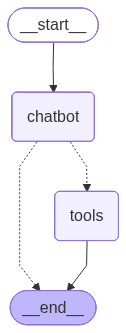

In [52]:
graph = graph_builer.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Lets use it

In [53]:
def chat(user_input:str, history):
    result = graph.invoke({'messages':[{'role':'user','content':user_input}]})
    return result['messages'][-1].content

gr.ChatInterface(chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


# Now we need to add memory

In [16]:
def says_bye(name: str):
    """A polite tool that says bye at end of each conversation!"""
    # print(f'Hi {name}!')
    return f"Bye {name}! I'm a tool that says bye!!!"

In [17]:
bye_tool = StructuredTool.from_function(
    name = "bye_tool",
    func=says_bye,
    description="A polite tool that says bye at end of each conversation!",
)

bye_tool.invoke('Sadeq')

# Must take at least one input!!!

"Bye Sadeq! I'm a tool that says bye!!!"

In [77]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

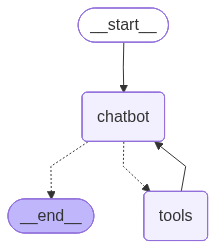

In [79]:
tools = [bye_tool]

graph_builder = StateGraph(State)

llm = init_chat_model(model_provider='groq',model='llama-3.1-8b-instant')
llm__with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {'messages': [llm__with_tools.invoke(state['messages'])]}

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('tools', ToolNode(tools=tools))

graph_builder.add_conditional_edges('chatbot', tools_condition, 'tools')
graph_builder.add_edge('tools','chatbot')
graph_builder.add_edge(START, 'chatbot')

graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {'configurable': {'thread_id':'2'}}

def chat(user_input: str, history):
    result = graph.invoke({'messages': [{'role':'user', 'content':user_input}]}, config=config)
    return result['messages'][-1].content

gr.ChatInterface(chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='whats my name?', additional_kwargs={}, response_metadata={}, id='7c79a880-4f0a-4904-8920-fbfd45fb9f37')]}
{'messages': [HumanMessage(content='whats my name?', additional_kwargs={}, response_metadata={}, id='7c79a880-4f0a-4904-8920-fbfd45fb9f37'), AIMessage(content="I don't have any information about your name. If you'd like to share it with me, I'd be happy to chat with you!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 228, 'total_tokens': 258, 'completion_time': 0.039143449, 'prompt_time': 0.012670071, 'queue_time': 0.091699382, 'total_time': 0.05181352}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--c8a5a6e2-8fb9-4e67-abe2-2b39ec4bffd9-0', usage_metadata={'input_tokens': 228, 'output_tokens': 30, 'total_tokens': 258}), HumanMessage(content='my name is Ja

Traceback (most recent call last):
  File "/home/sadeq/Projects/github/Introduction_to_LLMs/Agentic_Systems/LangGraph/prototype/.venv/lib/python3.12/site-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sadeq/Projects/github/Introduction_to_LLMs/Agentic_Systems/LangGraph/prototype/.venv/lib/python3.12/site-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sadeq/Projects/github/Introduction_to_LLMs/Agentic_Systems/LangGraph/prototype/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sadeq/Projects/github/Introduction_to_LLMs/Agentic_Systems/LangGraph/prototype/.venv/lib/python3.12/site-packages/gradio/blocks.py", line 162

{'messages': [HumanMessage(content='whats my name?', additional_kwargs={}, response_metadata={}, id='7c79a880-4f0a-4904-8920-fbfd45fb9f37'), AIMessage(content="I don't have any information about your name. If you'd like to share it with me, I'd be happy to chat with you!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 228, 'total_tokens': 258, 'completion_time': 0.039143449, 'prompt_time': 0.012670071, 'queue_time': 0.091699382, 'total_time': 0.05181352}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--c8a5a6e2-8fb9-4e67-abe2-2b39ec4bffd9-0', usage_metadata={'input_tokens': 228, 'output_tokens': 30, 'total_tokens': 258}), HumanMessage(content='my name is Javad', additional_kwargs={}, response_metadata={}, id='b738efd5-4a07-4b64-bb4d-af5ae8545eda'), AIMessage(content='', additional_kwargs={'tool_c

In [81]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='whats my name?', additional_kwargs={}, response_metadata={}, id='7c79a880-4f0a-4904-8920-fbfd45fb9f37'), AIMessage(content="I don't have any information about your name. If you'd like to share it with me, I'd be happy to chat with you!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 228, 'total_tokens': 258, 'completion_time': 0.039143449, 'prompt_time': 0.012670071, 'queue_time': 0.091699382, 'total_time': 0.05181352}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--c8a5a6e2-8fb9-4e67-abe2-2b39ec4bffd9-0', usage_metadata={'input_tokens': 228, 'output_tokens': 30, 'total_tokens': 258}), HumanMessage(content='my name is Javad', additional_kwargs={}, response_metadata={}, id='b738efd5-4a07-4b64-bb4d-af5ae8545eda'), AIMessage(content='', addit

In [82]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='whats my name?', additional_kwargs={}, response_metadata={}, id='7c79a880-4f0a-4904-8920-fbfd45fb9f37'), AIMessage(content="I don't have any information about your name. If you'd like to share it with me, I'd be happy to chat with you!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 228, 'total_tokens': 258, 'completion_time': 0.039143449, 'prompt_time': 0.012670071, 'queue_time': 0.091699382, 'total_time': 0.05181352}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7b3cfae3af', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--c8a5a6e2-8fb9-4e67-abe2-2b39ec4bffd9-0', usage_metadata={'input_tokens': 228, 'output_tokens': 30, 'total_tokens': 258}), HumanMessage(content='my name is Javad', additional_kwargs={}, response_metadata={}, id='b738efd5-4a07-4b64-bb4d-af5ae8545eda'), AIMessage(content='', addi

# Lets use a SQL database as our memory

In [19]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = 'memory.db'
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

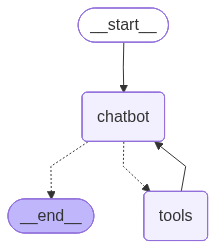

In [22]:
tools = [hi_tool, bye_tool]

class State(TypedDict):
    messages : Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = init_chat_model(model_provider='groq',model='llama-3.1-8b-instant')
llm__with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {'messages': [llm__with_tools.invoke(state['messages'])]}

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('tools', ToolNode(tools=tools))

graph_builder.add_conditional_edges('chatbot', tools_condition, 'tools')
graph_builder.add_edge('tools','chatbot')
graph_builder.add_edge(START, 'chatbot')

graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
config = {'configurable': {'thread_id':'4'}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi, my name is brooke.', additional_kwargs={}, response_metadata={}, id='f22c6908-5e16-45c8-88e3-a5406f1bc4bb'), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='d7de7428-3dbf-4aa0-a19d-e3bd93d3529e'), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='05b4c94c-289f-4a01-8285-afd43165b263')]}
{'messages': [HumanMessage(content='hi, my name is brooke.', additional_kwargs={}, response_metadata={}, id='f22c6908-5e16-45c8-88e3-a5406f1bc4bb'), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='d7de7428-3dbf-4aa0-a19d-e3bd93d3529e'), HumanMessage(content='what is my name?', additional_kwargs={}, response_metadata={}, id='05b4c94c-289f-4a01-8285-afd43165b263'), AIMessage(content='brooke', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 303, 'total_tokens': 306, 'completion_time': 0.007265317, '